In [ ]:
import sys
sys.path+= ["../"]
from ResonanceEquationsOfMotions import ResonanceEquations
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from ResonanceEquationsOfMotions import getOmegaMatrix

res_eqs = ResonanceEquations(5,2,n_quad_pts=51)

In [76]:
??res_eqs.eps

In [86]:
def set_masses_from_mratio_eps(mratio,eps,res_eqs):
    """
    Reset the planet masses of a ResonanceEquations object 
    by setting the planets' mass ratio and the epsilon
    parameter m1*m2/(m1+m2).
    
    Arguments
    ---------
    mratio : float
        Ratio of planet masses m2/m1
    eps : float
        Value of m1*m2 / (m1+m2)
    res_eqs : ResonanceEquationsOfMotions.ResonanceEquations
        Resonance eqautions instance to set masses for. 
    """
    res_eqs.m2 = mratio * res_eqs.m1
    epsOld = (res_eqs.m2 * res_eqs.m1) / (res_eqs.m1 + res_eqs.m2)
    res_eqs.m1 *= (eps / epsOld)
    res_eqs.m2 *= (eps / epsOld)

In [ ]:
def R_of_e1cos_e2cos(x,res_eqs,returnInputs=False):
    e1cos,e2cos=x
    e1 = np.abs(e1cos)
    e2 = np.abs(e2cos)
    orbels = np.array((res_eqs.alpha,e1,0,1,e2,0))
    z = res_eqs.orbels_to_dyvars(orbels)
    k = res_eqs.k
    z[0] = np.pi / res_eqs.k + np.arccos(np.sign((-1)**k * e1cos)) 
    z[1] = np.pi / res_eqs.k + np.arccos(np.sign((-1)**k * e2cos))
    if returnInputs:
        return z,res_eqs.Rav(z)
    return res_eqs.Rav(z)

In [ ]:
res_eqs.j = 5
res_eqs.k = 2
Ngrid=60
e1range = np.linspace(-0.2,0.2,Ngrid)
e2range = np.linspace(-0.5,0.4,Ngrid)
Z = np.zeros((Ngrid,Ngrid))
els = []
for i,e1cos in enumerate(e1range):
    for j,e2cos in enumerate(e2range):
        Z[j,i]= R_of_e1cos_e2cos((e1cos,e2cos),res_eqs)
    

X,Y = np.meshgrid(e1range,e2range)
plt.contour(X,Y,Z,np.linspace(*np.quantile(Z,(0,0.4)),30))

In [ ]:
from scipy.optimize import lsq_linear

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.reshape(-1)
# Maximum number of Newton root-finding steps to take
# and absolute tolerance for root determination.
MAX_ITER = 10
TOL = 1e-9
# Number of points for each ACR track
Npt = 80

# Eccentricities at which to start search for minimum disturbing function value. 
e_mins_init = (0.07,-0.3)

# Planet mass ratio range
planet_mass_ratios = np.logspace(-np.log10(7),np.log10(7),10)
#np.sort(np.append(1/np.linspace(1,5,3)[1:],np.linspace(1,5,3)))

acr_loc_dict = dict()
# Loop over resonances
for axI,jk in enumerate([(5,2),(3,1),(7,2),(4,1)]):
    
    ax = axes[axI]
    res_eqs.j,res_eqs.k = jk
    
    e_mins_init = (0.1,-0.3) 
    
    minroot = minimize(R_of_e1cos_e2cos,x0=e_mins_init,args=(res_eqs))
    acr_loc_dict.update({jk:dict()})      
    # Loop over planet mass ratios 
    for mratio in planet_mass_ratios:

        set_masses_from_mratio_eps(mratio,2e-4,res_eqs)
        
        # For som reason the 7:5 MMR needs some annoying hand-holding to 
        # get the ACR tracks correct. For the 7:5 MMR we'll build tracks 
        # from low AMD to high AMD instead.
        if res_eqs.j==7:            
            # Set the max amd form a rough estimate of the location of (e1*,e2*)
            y = res_eqs.orbels_to_dyvars([res_eqs.alpha,0.04,0.5 *np.pi,1,.24, 1.5 * np.pi])
            amdmax = y[-1]
        else:            
            y,_=R_of_e1cos_e2cos(minroot.x,res_eqs,returnInputs=True)
            amdmax = y[-1]
            
        # set the starting point at low AMD
        y = res_eqs.orbels_to_dyvars([res_eqs.alpha,0.01,0,1,.01, 0])
        amdmin = y[-1]
        
        if res_eqs.k==2:
            y[0] = 0.5*np.pi
            y[1] = 1.5 * np.pi
        else:
            y[0] = 0
            y[1] = np.pi            
        e1,e2 = np.zeros((2,Npt))    
        amdrange = np.logspace(np.log10(amdmin),np.log10(amdmax),Npt)
        y = np.array(y)
        lb = np.array([-np.pi,-np.pi, -1* y[2], -1 * y[3]])
        ub = np.array([np.pi,np.pi,np.inf,np.inf])
        
        # Loop over AMD values
        for i,amd0 in enumerate(amdrange):
            
            y[-1]=amd0
            f = res_eqs.H_flow(y)[:-1]
            J = res_eqs.H_flow_jac(y)[:-1,:-1]
            it=0
            
            # Newton method iteration
            while np.linalg.norm(f)>TOL and it < MAX_ITER:
                # Note-- using constrained least-squares
                # to avoid setting actions to negative 
                # values.
                lb[2:] =  -1* y[2:-1]
                dy = lsq_linear(J,-f,bounds=(lb,ub)).x
                y[:-1] = y[:-1] + dy
                f = res_eqs.H_flow(y)[:-1]
                J = res_eqs.H_flow_jac(y)[:-1,:-1]
                it+=1
            _,e1[i],_,_,e2[i],_ = res_eqs.dyvars_to_orbels(y) # 
            if it == MAX_ITER:
                print("Warning, max. iter. hit for (amd,gamma)=({:.2f},{:.2f})".format(amd0,mratio))
                
        ax.plot(np.append([0],e1),np.append([0],e2),label="{:.2f}".format(mratio),lw=3)
        
        acr_loc_dict[jk].update({mratio:[np.append([0],e1),np.append([0],e2)]})
        
    ax.set_xlabel(r"$e_1$")
    ax.set_ylabel(r"$e_2$")
    ax.set_title(r"{:d}:{:d}".format(res_eqs.j,res_eqs.j-res_eqs.k))
    ax.legend(title=r"$m_2/m_1$")


Export computed ACR tracks to a binary file.

In [ ]:
import pickle

with open("./ACR_locations_data.pkl","wb") as fi:
    pickle.dump(acr_loc_dict,fi)

In [69]:
import pickle

with open("./ACR_locations_data.pkl","rb") as fi:
    acr_loc_dict = pickle.load(fi)

In [74]:
keys = list(acr_loc_dict[(3,1)].keys())

In [75]:
acr_loc_dict[(3,1)][keys[0]]

[array([0.        , 0.00829379, 0.00833487, 0.00837944, 0.00842778,
        0.00848023, 0.00853711, 0.0085988 , 0.00866569, 0.00873821,
        0.00881681, 0.008902  , 0.00899429, 0.00909426, 0.0092025 ,
        0.00931965, 0.00944639, 0.00958345, 0.00973158, 0.00989159,
        0.01006431, 0.01025063, 0.01045146, 0.01066775, 0.01090048,
        0.01115068, 0.01141939, 0.01170769, 0.01201667, 0.01234747,
        0.01270124, 0.0130792 , 0.01348256, 0.01391261, 0.01437069,
        0.01485819, 0.01537662, 0.01592756, 0.01651273, 0.017134  ,
        0.01779343, 0.01849327, 0.01923605, 0.02002459, 0.02086209,
        0.02175214, 0.02269884, 0.02370685, 0.02478153, 0.02592901,
        0.02715634, 0.02847169, 0.02988444, 0.03140549, 0.03304747,
        0.03482502, 0.03675513, 0.03885755, 0.0411552 , 0.04367466,
        0.04644671, 0.0495069 , 0.05289607, 0.05666083, 0.06085388,
        0.06553391, 0.07076491, 0.07661445, 0.08315061, 0.09043716,
        0.09852705, 0.10745494, 0.11723047, 0.12

# Save $\Delta$ information

In [1]:
import sys
sys.path+= ["../"]
from ResonanceEquationsOfMotions import ResonanceEquations
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from ResonanceEquationsOfMotions import getOmegaMatrix

res_eqs = ResonanceEquations(3,1,n_quad_pts=51)

In [2]:
def printmatrix(M,n=5):
    for row in np.around(M,n):
        for num in row:
            print("{:.2g}".format(num),end="  ")
        print()

from ResonantRV_Utils import acr_function

from scipy.optimize import lsq_linear
def newton_solve_equilibrium(res_eqs,t,acr_fn,TOL=1e-9,MAX_ITER=10):

    mratio = res_eqs.m2/res_eqs.m1
    e10,e20 = acr_fn(mratio,t)
    y = res_eqs.orbels_to_dyvars((res_eqs.alpha,e10,0,1,e20,np.pi))
    if res_eqs.k==2:
        y[0] = 0.5*np.pi
        y[1] = 1.5 * np.pi
    else:
        y[0] = 0
        y[1] = np.pi            

    lb = np.array([-np.pi,-np.pi, -1* y[2], -1 * y[3]])
    ub = np.array([np.pi,np.pi,np.inf,np.inf])

    f = res_eqs.H_flow(y)[:-1]
    J = res_eqs.H_flow_jac(y)[:-1,:-1]
    it=0

    # Newton method iteration
    while np.linalg.norm(f)>TOL and it < MAX_ITER:
        # Note-- using constrained least-squares
        # to avoid setting actions to negative 
        # values.
        lb[2:] =  -1* y[2:-1]
        dy = lsq_linear(J,-f,bounds=(lb,ub)).x
        y[:-1] = y[:-1] + dy
        f = res_eqs.H_flow(y)[:-1]
        J = res_eqs.H_flow_jac(y)[:-1,:-1]
        it+=1
    if it==MAX_ITER:
        raise RuntimeError("Max iterations reached!")
    return y
    #els = res_eqs.dyvars_to_orbels(y)
    #return np.array(els)

In [52]:
res_eqs.j = 3
res_eqs.k = 1

acrfn = acr_function(res_eqs.j,res_eqs.k)

res_eqs.m1 = 5e-4
res_eqs.m2 = 5e-4

equilibrium = newton_solve_equilibrium(res_eqs,0.25,acrfn,TOL=1e-13)


s = (res_eqs.j - res_eqs.k) / res_eqs.k

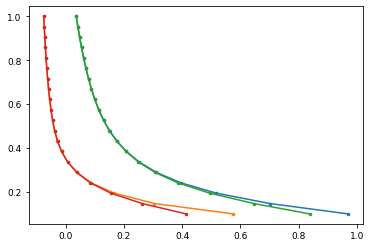

In [68]:
for mcombo in [(5e-4,5e-4),(1e-4,5e-4),(1e-3,1e-3),(1e-3,5e-3)]:
    res_eqs.m1 = mcombo[0]
    res_eqs.m2 = mcombo[1]
    N=20
    I1,I2,amd = np.zeros((3,N))
    ts=np.linspace(0.1,1,N)
    for i,t in enumerate(ts):
        I1[i],I2[i],amd[i] = newton_solve_equilibrium(res_eqs,t,acrfn)[2:]

    plt.plot((I1+I2-amd) / res_eqs.eps,ts,'.-')

In [101]:
planet_mass_ratios = np.logspace(0,np.log10(5),10)
ts=np.linspace(0.1,1,50)

I1eq,I2eq,AMDeq,e1eq,e2eq,Delta_by_eps,AMDdiff_by_eps = np.zeros((7,10,50))

for j,mratio in enumerate(planet_mass_ratios):
    set_masses_from_mratio_eps(mratio,5e-4,res_eqs)
    for i,t in enumerate(ts):
        zeq = newton_solve_equilibrium(res_eqs,t,acrfn)
        I1eq[j,i],I2eq[j,i],AMDeq[j,i] = zeq[2:]
        
        AMDdiff_by_eps[j,i] = (AMDeq[j,i] - (I1eq[j,i]+I2eq[j,i])) / res_eqs.eps
        
        a1,e1,theta1,a2,e2,theta2 = res_eqs.dyvars_to_orbels(zeq)
        e1eq[j,i] = e1        
        e2eq[j,i] = e2
        
        pratio = (a1/a2)**(-1.5)
        Delta = (res_eqs.j-res_eqs.k) * pratio /res_eqs.j - 1
        
        Delta_by_eps[j,i] = Delta/res_eqs.eps
        
        

ACR_3to2_equilibrium_results = {
    'eps':5e-4,
    'mass_ratio':planet_mass_ratios,
    'tvals':ts,
    'I1':I1eq,
    'I2':I2eq,
    'AMD':AMDeq,
    'e1':e1eq,
    'e2':e2eq,
    'Delta_by_eps':Delta_by_eps,
    'AMDdiff_by_eps':AMDdiff_by_eps
}


In [122]:
sim=rb.Simulation()

In [120]:
with open("../data/ACR_3to2_equilibrium_results.pkl",'wb') as fi:
    pickle.dump(ACR_3to2_equilibrium_results,fi)

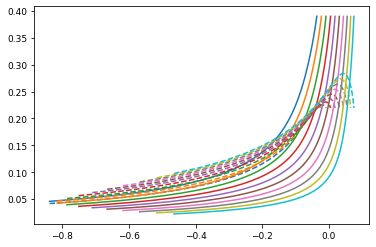

In [102]:
for i in range(10):
    l,=plt.plot(AMDdiff_by_eps[i],e2eq[i])
    plt.plot(AMDdiff_by_eps[i],e1eq[i],'--',color=l.get_color())

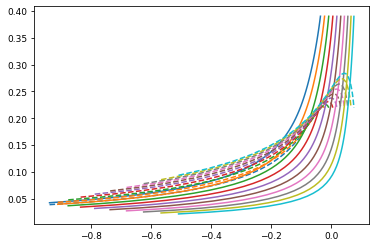

In [100]:
for i in range(10):
    l,=plt.plot(AMDdiff_by_eps[i],e2eq[i])
    plt.plot(AMDdiff_by_eps[i],e1eq[i],'--',color=l.get_color())

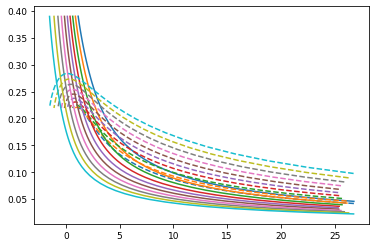

In [103]:
for i in range(10):
    l,=plt.plot(Delta_by_eps[i],e2eq[i])
    plt.plot(Delta_by_eps[i],e1eq[i],'--',color=l.get_color())

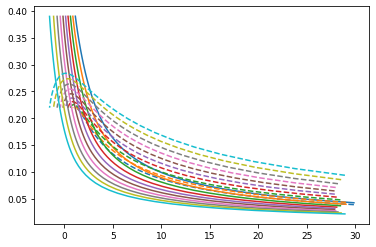

In [99]:
for i in range(10):
    l,=plt.plot(Delta_by_eps[i],e2eq[i])
    plt.plot(Delta_by_eps[i],e1eq[i],'--',color=l.get_color())

In [92]:
set_masses_from_mratio_eps(7,3e-4,res_eqs)
res_eqs.m1,res_eqs.m2,res_eqs.eps

(0.00034285714285714285, 0.0024, 0.00029992290340081666)

In [67]:
acrfn(1,.1)

(0.03077164791614371, 0.03342542272406825)

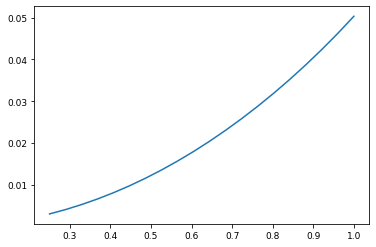

In [59]:
plt.plot(ts,amd)


# Nbody root finding

In [4]:
from scipy.optimize import root,root_scalar

In [5]:
def get_sim_hk_array(sim,j,k):
    ps = sim.particles
    p1 = ps[1]
    p2 = ps[2]
    phi = j * p2.l - (j-k) * p1.l
    theta1 = phi - k * p1.pomega
    theta2 = phi - k * p2.pomega
    e1 = p1.e
    e2 = p2.e
    h1 = e1 * np.cos(theta1)
    k1 = e1 * np.sin(theta1)
    h2 = e2 * np.cos(theta2)
    k2 = e2 * np.sin(theta2)
    return np.array([h1,k1,h2,k2])
    

def synodic_angle_vs_time(t,sim):
    sim.integrate(t)
    return np.mod(sim.particles[2].l-sim.particles[1].l + np.pi,2*np.pi) - np.pi

def root_finding_objective_function(x,amd,res_eqs,full_output=False):
    
    z = np.append(x,amd)
    sim,_ = res_eqs.dyvars_to_rebound_simulation(z)
    
    
    hk_arr_init = get_sim_hk_array(sim,res_eqs.j,res_eqs.k)
    
    # Integrate simulation for exactly one synodic period
    ps = sim.particles
    Tsyn = 2 * np.pi / (ps[1].n-ps[2].n)
    if np.abs((res_eqs.j-res_eqs.k)*ps[2].P/ps[1].P/res_eqs.j - 1)>0.075:
        return np.inf * np.ones(4)
    sim.integrate(res_eqs.k * Tsyn)
    Q0 = np.mod(sim.particles[2].l-sim.particles[1].l,2*np.pi)
    t0 = sim.t
    dQ = np.mod(np.pi-Q0,2*np.pi)-np.pi
    t1 = t0 + dQ / (ps[2].n - ps[1].n)

    root_info = root_scalar(
        synodic_angle_vs_time,
        x0=t1,
        bracket=(t1-0.01*Tsyn,t1+0.01*Tsyn),
        args=(sim)
    )
    if not root_info.converged:
        raise RuntimeError("Failed to locate conjunction!")

    hk_arr_final = get_sim_hk_array(sim,res_eqs.j,res_eqs.k)        
    dhk_arr = hk_arr_final - hk_arr_init
    
    fun =  dhk_arr
    
    if full_output:
        return {'sim':sim,'period':root_info.root,'fun':dhk_arr}
    
    return fun

In [23]:
def plot_data_no_scaling(data,j,k):
    sim = data['sim']
    sim.integrate(0)
    ps = sim.particles
    m1,m2 = ps[1].m,ps[2].m
    mtot = m1+m2
    times = np.linspace(0,data['period'],100)
    N = len(times)
    Q,theta1,theta2,Ne1,Ne2,NDelta = np.zeros((6,N))
    for i,t in enumerate(times):
        sim.integrate(t)
        orbits = sim.calculate_orbits(jacobi_masses=True)
        Q[i] = np.mod(orbits[1].l - orbits[0].l ,2*np.pi)
        theta1[i] = j * orbits[1].l - (j - k) * orbits[0].l - k * orbits[0].pomega
        theta2[i] = j * orbits[1].l - (j - k) * orbits[0].l - k * orbits[1].pomega
        NDelta[i] = (j - k) * orbits[1].P / orbits[0].P / j - 1
        Ne1[i] = orbits[0].e
        Ne2[i] = orbits[1].e
    theta1 = np.mod(theta1+k*np.pi,2*np.pi)
    theta2 = np.mod(theta2,2*np.pi)

    fig,ax = plt.subplots(1,3,figsize=(15,3))
    ax[0].plot(Q,(theta1-np.pi),'.')
    ax[0].plot(Q,(theta2-np.pi),'.')
    ax[0].axhline(0)
    l1,=ax[1].plot(Q,(Ne1-np.mean(Ne1)),'.')
    l2,=ax[1].plot(Q,(Ne2-np.mean(Ne2)),'.')
    
    ax[2].plot(Q,NDelta,'.')
    ax[2].axhline(np.mean(NDelta),color='k')
    ax[2].set_title(r"$\Delta$")




In [40]:
res_eqs.j = 3
res_eqs.k = 1

acrfn = acr_function(res_eqs.j,res_eqs.k)

res_eqs.m1 = 5e-4
res_eqs.m2 = 1e-3

equilibrium = newton_solve_equilibrium(res_eqs,0.6,acrfn,TOL=1e-13)

s = (res_eqs.j - res_eqs.k) / res_eqs.k

In [41]:
s1,s2,I1,I2,amd = res_eqs.mean_to_osculating_dyvars(0,equilibrium)
x0=np.array((s1,s2,I1,I2))
args = (amd,res_eqs)
root_finding_objective_function(x0,*args)
root_result = root(root_finding_objective_function,x0,args=args)
data= root_finding_objective_function(root_result.x,*args,full_output=True)

Qs=np.linspace(0,2*np.pi)
zcorr= res_eqs.mean_to_osculating_dyvars(Qs,equilibrium)

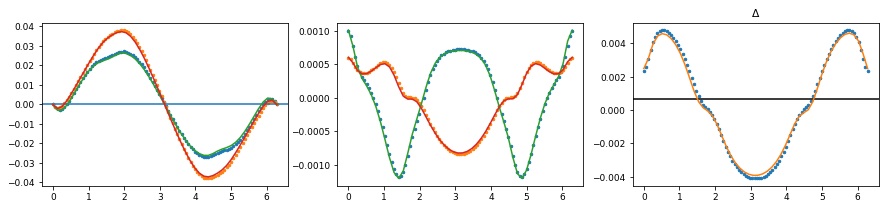

In [42]:
orbels = np.array([res_eqs.dyvars_to_orbels(zc) for zc in np.real(zcorr).T])
a1,e1,theta1,a2,e2,theta2=orbels.T

plot_data_no_scaling(data,3,1)
fig = plt.gcf()
ax=fig.axes
ax[0].plot(Qs,theta1)
ax[0].plot(Qs,theta2-np.pi)

ax[1].plot(Qs,e1-np.mean(e1))
ax[1].plot(Qs,e2-np.mean(e2))


Delta = 2*(a2/a1)**(1.5)/3 -1
ax[2].plot(Qs,Delta)

In [43]:
import rebound as rb

In [47]:
Q = np.random.uniform(0,2*np.pi) 
z0 = res_eqs.mean_to_osculating_dyvars(Q,equilibrium)
sim,_= res_eqs.dyvars_to_rebound_simulation(equilibrium,Q=Q)
orbits = sim.calculate_orbits(jacobi_masses=True)
j,k= res_eqs.j,res_eqs.k
print("dQ: {}".format(Q-np.mod(orbits[1].l - orbits[0].l,2*np.pi)))
print("dtheta1: {}".format(np.mod(z0[0],2*np.pi) - np.mod(j * orbits[1].l - (j-k) * orbits[0].l- k * orbits[0].pomega,2*np.pi)))
print("dtheta2: {}".format(np.mod(z0[1],2*np.pi) - np.mod(j * orbits[1].l - (j-k) * orbits[0].l- k * orbits[1].pomega,2*np.pi)))



dQ: 6.217248937900877e-15
dtheta1: 1.9539925233402755e-14
dtheta2: 1.3766765505351941e-14


(-1, 1)

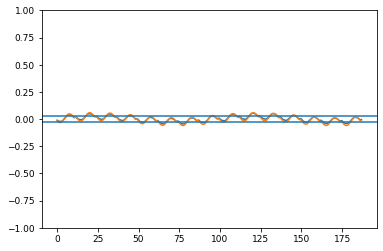

In [48]:
# N-body
ps = sim.particles
n10,n20 = [p.n for p in ps[1:]]
Tsyn = 2 * np.pi / (n10 - n20)
times = np.linspace(0,15 * Tsyn,400)
Q_nb,Delta_nb = np.zeros((2,len(times)))
dyvars_nb = np.zeros((len(times),len(equilibrium)))

for i,t in enumerate(times):
    sim.integrate(t)
    orbits = sim.calculate_orbits()
    Q_nb[i] = np.mod(orbits[1].l - orbits[0].l, 2*np.pi)
    Pratio = orbits[1].P/orbits[0].P
    Delta_nb[i] = s * Pratio/(s+1) - 1
    theta1 = res_eqs.j * orbits[1].l - (res_eqs.j -res_eqs.k) * orbits[0].l - res_eqs.k * orbits[0].pomega
    theta2 = theta1 + res_eqs.k * (orbits[0].pomega - orbits[1].pomega)
    orbels = (orbits[0].a,orbits[0].e,theta1,orbits[1].a,orbits[1].e,theta2)
    dyvars_nb[i] = res_eqs.orbels_to_dyvars(orbels)

plt.plot(times,np.mod(dyvars_nb[:,0]+np.pi,2*np.pi)-np.pi)
plt.plot(times,np.mod(dyvars_nb[:,1],2*np.pi)-np.pi)
plt.axhline(0.03)
plt.axhline(-0.03)
plt.ylim(-1,1)

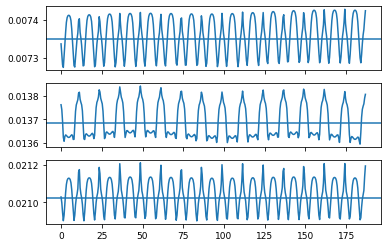

In [49]:
fig,ax = plt.subplots(3,sharex=True)
for i in range(2,5):
    ax[i-2].plot(times,dyvars_nb[:,i])
    ax[i-2].axhline(equilibrium[i])

# Test rebound sim with inclination, periods